<h1> Predictive Maintainance MVP

In this notebook we train an ML model to predict whether a part is faulty or not based on sensor readings from the part. For training, we use a dataset which is adapted from a real predictive maintenance use case. The columns and rows have been anonymized, but the overall statistics of the dataset has been preserved. This will allow you to see some of the typical challenges that arise when dealing with ML for predictive maintenance.

We will go over the key aspects of a typical data science pipeline:

1. data ingest
2. data exploration <br/>
3. model training <br/>
4. model deployment <br/>

Here we train an XGBoost model, using Amazon SageMaker's built in algorithms to predict whether a part is faulty or not in assembly line for predictive maintainance. Once the faulty part is found, it will be removed from the line and taken for repair.

Instead of deploying a live endpoint here, we will deploy the model locally on the Greengrass core. But to test the model, we will test the model predictions on a test dataset and plot relevant metrics.

<h2> Import libraries and get data into dataframe

In [1]:
import sagemaker
import numpy as np
import os
import json

sagemaker_session = sagemaker.Session()
bucket = None #Replace with the bucket name created for you by CloudFormation
prefix = 'xgbdata'
LOCAL_DIR = 'training_data'
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::389535300735:role/service-role/AmazonSageMaker-ExecutionRole-20190823T110499


In [5]:
# Path to upload the trained model
xgb_upload_location = os.path.join('s3://{}/{}'.format(bucket, 'xgb'))
print(xgb_upload_location)

s3://iot-ml-predictive-maintenance/xgb


In [6]:
# Grab the latest XGBoost container from ECR
region = 'us-east-1'
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')
print(container)

811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1


In [7]:
# The training data doesn't have any column name headers so lets include those first
with open('cols.txt', 'r') as f:
    cols = json.load(f)

In [8]:
# Read the data directly locally
import pandas as pd

DATANAME = 'train.csv'

datorig = pd.read_csv('{}/{}'.format(LOCAL_DIR, DATANAME), names = cols)

In [9]:
datorig.head(10)

,Response,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,...,Sensor_159,Sensor_160,Sensor_161,Sensor_162,Sensor_163,Sensor_164,Sensor_165,Sensor_166,Sensor_167,Sensor_168
0,0,0.056,0.041,-0.179,-0.179,-0.056,0.070,-0.022,-0.072,-0.077,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000
1,0,-0.042,-0.086,0.294,0.312,-0.100,0.025,0.022,0.168,0.097,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000
2,0,0.115,0.071,-0.179,-0.179,0.161,0.025,-0.030,-0.112,0.041,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,-0.094
3,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000
4,0,-0.042,-0.101,-0.052,-0.052,0.118,0.025,0.008,0.088,0.102,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000
5,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.124,0.157,0.014,0.018,-0.263,0.045,-0.422,-0.027,0.00,0.000
6,0,0.010,0.026,-0.197,-0.197,-0.013,-0.021,-0.015,-0.072,0.173,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000
7,0,-0.068,0.004,-0.197,-0.161,0.031,-0.066,0.008,-0.072,-0.046,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.07,0.000
8,0,-0.016,-0.056,-0.033,-0.016,0.074,0.116,0.008,0.048,-0.123,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000
9,0,0.016,0.026,-0.179,-0.179,0.118,0.025,-0.015,-0.072,0.010,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000


The data consists of 2 parts:

1. Response: this is the faulty (1) or not faulty (0) signal. <br/>
2. Sensor readings: the remaining 168 columns correspond to Sensor readings.

Note the large number of 0s in the dataset. This is because not all sensors fire at the same time, and each reading only comes from a subset of the sensors. 

<h2> Data Exploration

Before building an ML model, let's go ahead and explore the dataset and look for some correlations.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Class Imbalance
One of the first things you notice in predictive maintenance is CLASS IMBALANCE.

CLASS IMBALANCE occurs when one class (in this case faulty labels) is much less prevalent than the not faulty label.

This is a problem for ML models as this means that the model may not see enough examples of the faulty class to train accurately. Seen another way, this means that a model that always predicts a label to be not faulty is 90.8% accurate!

Our ML model will need to beat this accuracy to be useful from a business perspective. There are a number of ways for dealing with imbalanced classification problems -- upsampling, downsampling, SMOTE to name a few. For this POC we will not use these approaches and train a minimal viable model

Percent of Faulty Examples = 10.2


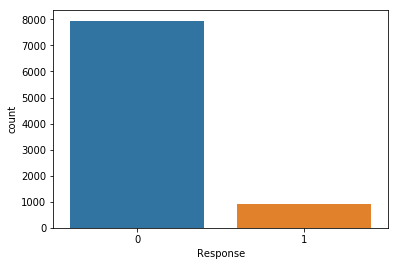

In [22]:
sns.countplot(datorig.Response)
print("Percent of Faulty Examples = {:.1f}".format(len(datorig[datorig['Response']==1])/len(datorig)*100))

### Correlations

Next let's extract some correlations between the Response label and the Sensor features. Since we have so many features, we can plot a heatmap for the correlations.

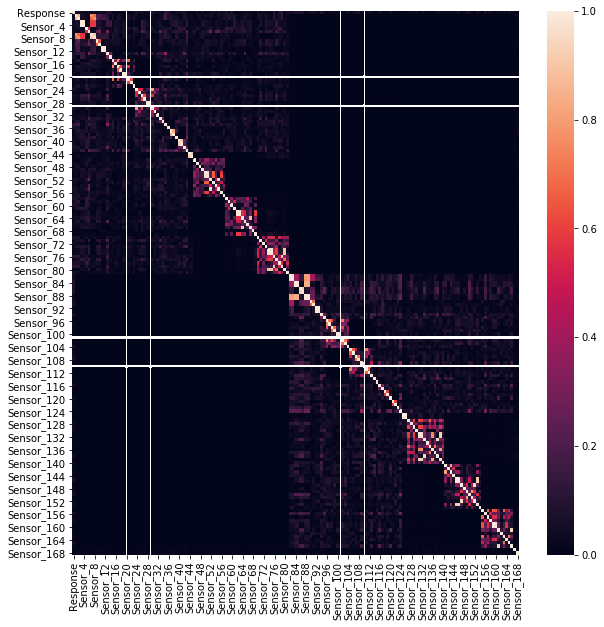

In [27]:
corr = datorig.corr()

plt.figure(figsize= (10, 10))
sns.heatmap(np.abs(corr))
plt.show()

Look at the correlation heatmap above: what do you notice?

There are striking blocks of high correlations amidst relatively little correlations between other features. 
Physically these blocks could be sensors that are all firing at once on a single assembly line, or assigned to a single part. Our ML model must be able to deal with these strong and weak correlations well. A linear model may not be able to perform well when features are strongly correlated. For this reason, we choose a tree based gradient boosting model like XGBoost.

Traditionally, we might want to consider methods like PCA to perform some dimensionality reduction, but this comes at a cost of interpretability. In our factory, we want to determine which sensor is giving the anomalous signal corresponding to the faulty part, and PCA will mix the sensor signals together. 

In [29]:
# identify what sensors correlate strongly with the faulty label
index_list = list(corr['Response'].dropna().index)
val_list = np.argsort(np.abs(corr['Response'].dropna().values))[::-1]

In [46]:
# Get most corelated variables to the Response label. The response variable is ofcourse most correlated with itself 
#and removed
top_corrs = [index_list[x] for x in val_list[:5]]
top_corrs

['Response', 'Sensor_79', 'Sensor_76', 'Sensor_35', 'Sensor_36']

In [47]:
reduceddat = datorig[top_corrs]
reduceddat.head()

,Response,Sensor_79,Sensor_76,Sensor_35,Sensor_36
0,0,0.000,0.000,0.000,0.000
1,0,-0.028,-0.004,0.115,-0.083
2,0,0.071,0.011,0.000,0.000
3,0,0.000,0.000,0.000,0.000
4,0,0.000,0.000,0.000,0.000


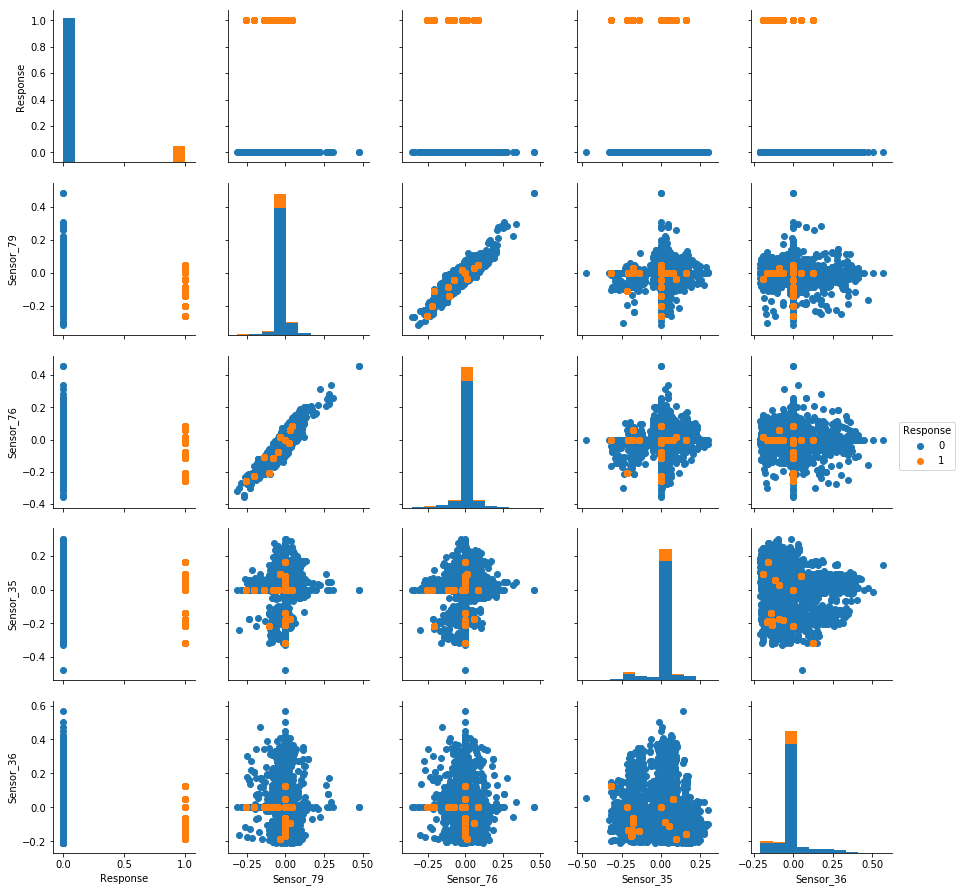

In [49]:
# Plot how the top correlated sensor readings are correlated with each other and the Faulty and Not Faulty Labels
g = sns.PairGrid(reduceddat, hue="Response")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()
plt.show()

<h2> Model Training and Deployment

Having explored the dataset some, we can now build a model.
Our guiding principles for Model choice are as follows:

1. There are multiple sensors with weak correlations to the final output variable <br/>
2. Outputs are highly skewed and imbalanced, so our baseline model already has 90% accuracy. The ML model will need to do better to drive business value <br/>
3. Sensor data may itself be correlated with each other and not all sensors may fire at once <br/>

A linear model may not work as well in this situation as the outputs are imbalanced and in real life sensor data may be highly correlated. For this reason, we choose a gradient boosting based tree model called XGBoost. 

SageMaker has a built in implementation of the XGBoost algorithm designed to work at scale. The default data type for XGBoost is LIBSVM format. But our data is in csv and XGBoost also accepts a csv input but it needs to be specified in the 'content_type' variable. We do this first.

Next we train a model: This should take less than 5 minutes and incur about 50 seconds of training cost. Remember that SageMaker charges you for the time it takes the train and the infrastructure you train on. There are no upfront charges or recurring costs. Once training is complete, SageMaker tears it down automatically.

In [50]:
# NExt we need to push the training and test data to S3
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sagemaker_session.upload_data(path='training_data', bucket=bucket, key_prefix=train_channel)
sagemaker_session.upload_data(path='test_data', bucket=bucket, key_prefix=validation_channel)

#s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
#s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_channel = sagemaker.session.s3_input('s3://{}/{}'.format(bucket, train_channel), content_type ='csv')
s3_valid_channel = sagemaker.session.s3_input('s3://{}/{}'.format(bucket, validation_channel), content_type ='csv')


In [52]:
%%time
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c4.8xlarge',
                                    output_path=xgb_upload_location,
                                    sagemaker_session=sagemaker_session)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_train_channel, 'validation': s3_valid_channel})

2019-09-27 19:32:07 Starting - Starting the training job...
2019-09-27 19:32:11 Starting - Launching requested ML instances......
2019-09-27 19:33:14 Starting - Preparing the instances for training...
2019-09-27 19:34:07 Downloading - Downloading input data...
2019-09-27 19:34:29 Training - Downloading the training image..
Arguments: train
[2019-09-27:19:34:42:INFO] Running standalone xgboost training.
[2019-09-27:19:34:42:INFO] File size need to be processed in the node: 8.46mb. Available memory size in the node: 52413.89mb
[2019-09-27:19:34:42:INFO] Determined delimiter of CSV input is ','
[19:34:42] S3DistributionType set as FullyReplicated
[19:34:42] 8848x168 matrix with 1486464 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-09-27:19:34:42:INFO] Determined delimiter of CSV input is ','
[19:34:42] S3DistributionType set as FullyReplicated
[19:34:42] 2212x168 matrix with 371616 entries loaded from /opt/ml/input/data/validation?format=csv&labe


2019-09-27 19:34:54 Uploading - Uploading generated training model
2019-09-27 19:34:54 Completed - Training job completed
Billable seconds: 48
CPU times: user 413 ms, sys: 24.5 ms, total: 438 ms
Wall time: 3min 12s


<h2> Model deployment and predictions

There are several options to deploy the model:

1. Live Endpoint: this approach is suitable for low latency inference against live data in the cloud. Since we want to make inferences in our factory environment, we don't choose this option. <br/>


2. Batch Transform: to test out our model accuracy, we run inferences against some test data. As our dataset is small, the test set here is just the training set + validation set. In reality, this should be completely unseen data, but this will suffice for our MVP. <br/>


3. Deploy on Greengrass: Instead of deploying a live endpoint in the AWS Cloud, we will deploy the model locally on our Greengrass core. Follow the steps in the lab to accomplish this. <br/>

<h2> Batch Transform 

Instead of deploying a live endpoint, let's run a Batch Transform job to test the model accuracy and other metrics on the entire dataset. This dataset is saved locally, so we need to first port it over to S3.


Once the dataset is in S3, we can call SageMaker Batch Transform to perform inference on the entire dataset and save the output to file

In [53]:
# drop the Response column from the dataset.
test_set = pd.read_csv('mbdataset.csv')
resp = test_set['0']
test_set = test_set.drop(columns = ['0'])
test_set.to_csv('test.csv', index =False, header = False)

In [54]:
test_channel = prefix + '/test'
sagemaker_session.upload_data('test.csv', bucket=bucket, key_prefix=test_channel)

's3://iot-ml-predictive-maintenance/xgbdata/test/test.csv'

Run the batch transform job. Specify the input file location and point batch transform to a path for storing the model outputs.

In [56]:
%%time
batch_input = 's3://{}/{}'.format(bucket, test_channel) # The location of the test dataset

batch_output = 's3://{}/{}/batch-inference'.format(bucket, test_channel) # The location to store the results of the batch transform job

transformer = xgb.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

try:
    transformer.wait()
except Exception as e:
    pass

.............................................*
CPU times: user 235 ms, sys: 9.74 ms, total: 245 ms
Wall time: 3min 46s


In [57]:
data_dir = './data/inference'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

!aws s3 cp --recursive $transformer.output_path $data_dir

download: s3://iot-ml-predictive-maintenance/xgbdata/test/batch-inference/test.csv.out to data/inference/test.csv.out


In [59]:
y_test = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
y_vals = np.round(y_test.values)

## Metrics and economics

Lets get some model metrics.

From a business perspective, we need to consider more than just the model accuracy but let's get that first.

Two other metrics to look at are precision and recall. How do these manifest themselves in IoT Predictive maintenance?

Precision is a measure of the number of false positives. High precision indicates low false positives. The added cost of high false positives is that the factory engineers and workers have to spend time and money troubleshooting and performing maintenance when its not required.

Imagine the other situation: if the part is actually in need of maintenance and our model predicts that it is fine. 
In IoT settings, particularly in heavy industries, a large cost is incurred when there is "unexpected downtime". Especially for mission critical equipment, this can shut down the entire site. A high recall score (low false negatives) will help minimize this as it will ensure that when a part *is* in need of maintenance, it is flagged.

An understanding of precision and recall must be tied in with the economics of the particular use case. 

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [61]:
print("Model Accuracy = {} %".format(accuracy_score(resp.values, y_vals)*100))

Model Accuracy = 96.44633330319196 %


In [62]:
print(classification_report(resp.values, y_vals))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9946
           1       0.98      0.66      0.79      1113

   micro avg       0.96      0.96      0.96     11059
   macro avg       0.97      0.83      0.88     11059
weighted avg       0.97      0.96      0.96     11059



Confusion matrix, without normalization
[[9931   15]
 [ 378  735]]


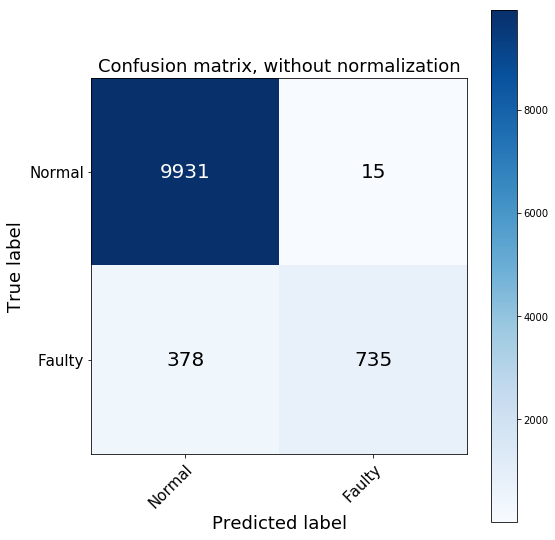

In [75]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
     # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
    plt.tick_params(labelsize=15)  
    plt.xlabel('Predicted label', fontsize=18)
    plt.ylabel('True label',fontsize =18)
    plt.title(title, fontsize=18)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center", fontsize=20,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(resp.values, y_vals, classes=['Normal', 'Faulty'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.show()

Our model is not perfect but does 6% better than the naive model with 90% accuracy. What this means is that although the model still misses some examples of faulty labels, it correctly captures a large number of them that the naive model would not be able to.

We can now deploy this model on to Greengrass.

Go back to the predictive maintenance tutorial to continue building out this use case